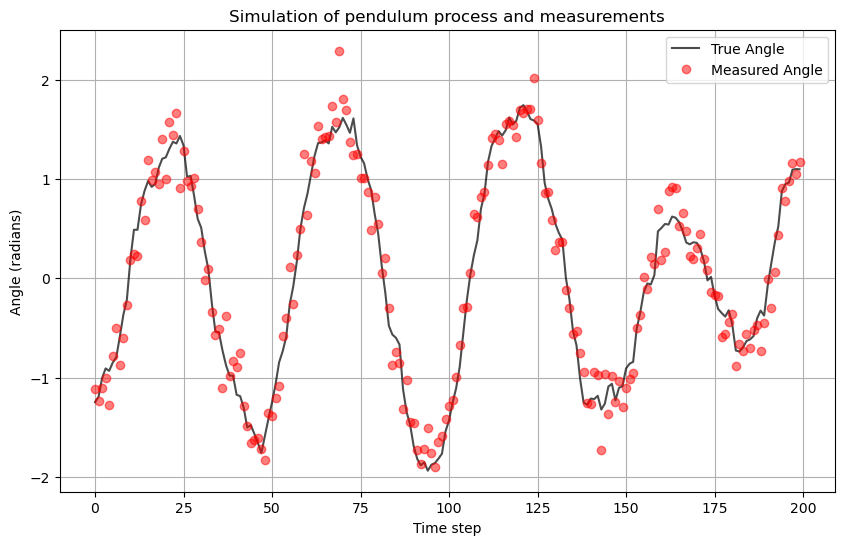

EKF RMSE: 0.6261


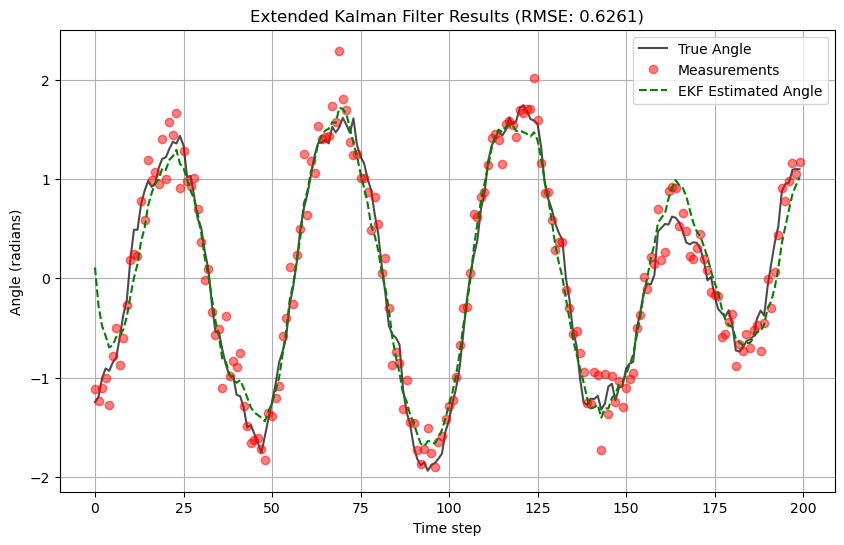

Training iteration 1...
Iteration 1, DKF RMSE: 0.6411, Avg Loss: 0.0249


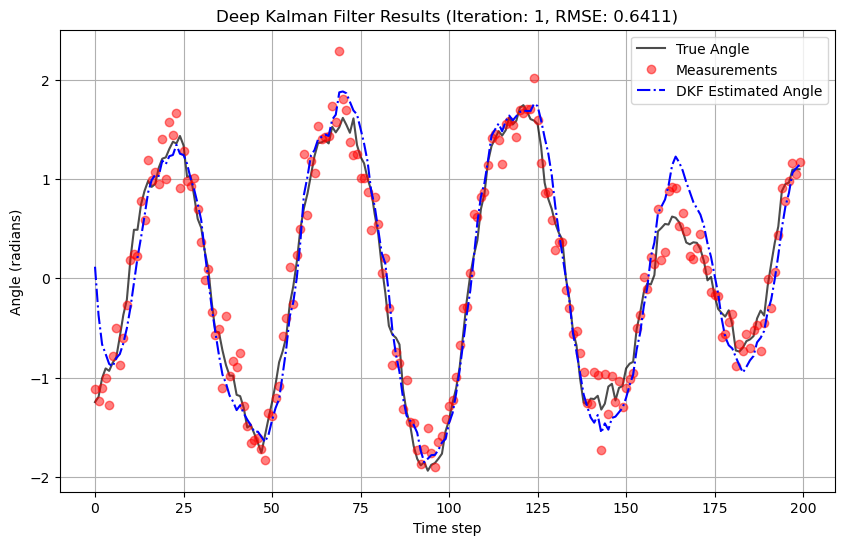

Training iteration 2...
Iteration 2, DKF RMSE: 0.6485, Avg Loss: 0.0220
Training iteration 3...
Iteration 3, DKF RMSE: 0.6545, Avg Loss: 0.0211
Training iteration 4...
Iteration 4, DKF RMSE: 0.6946, Avg Loss: 0.0215
Training iteration 5...
Iteration 5, DKF RMSE: 0.7443, Avg Loss: 0.0205
Training iteration 6...
Iteration 6, DKF RMSE: 1.1109, Avg Loss: 0.0203
Training iteration 7...
Iteration 7, DKF RMSE: 0.6899, Avg Loss: 0.0197
Training iteration 8...
Iteration 8, DKF RMSE: 0.9215, Avg Loss: 0.0202
Training iteration 9...
Iteration 9, DKF RMSE: 0.5839, Avg Loss: 0.0195
Training iteration 10...
Iteration 10, DKF RMSE: 0.6566, Avg Loss: 0.0190


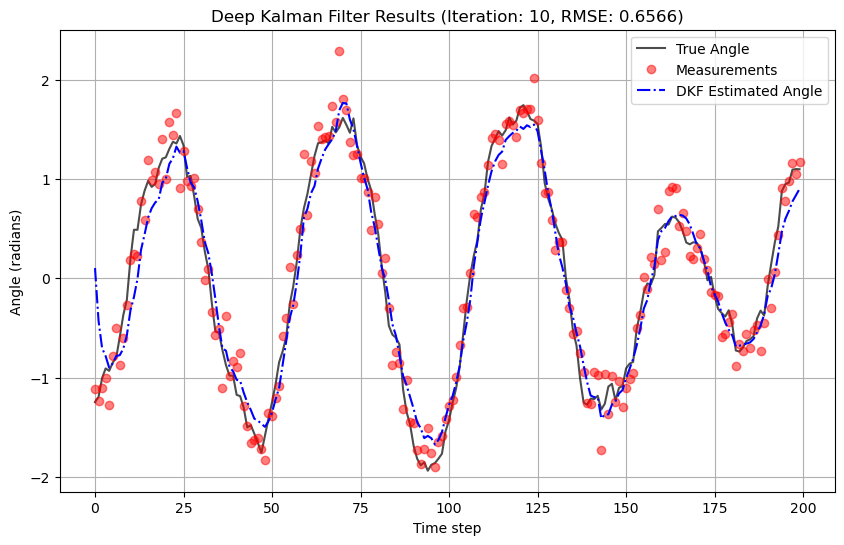

Training iteration 11...
Iteration 11, DKF RMSE: 0.6566, Avg Loss: 0.0185
Training iteration 12...
Iteration 12, DKF RMSE: 0.6906, Avg Loss: 0.0181
Training iteration 13...
Iteration 13, DKF RMSE: 0.5798, Avg Loss: 0.0181
Training iteration 14...
Iteration 14, DKF RMSE: 0.7390, Avg Loss: 0.0175
Training iteration 15...
Iteration 15, DKF RMSE: 0.7477, Avg Loss: 0.0189
Training iteration 16...
Iteration 16, DKF RMSE: 0.7518, Avg Loss: 0.0178
Training iteration 17...
Iteration 17, DKF RMSE: 0.6572, Avg Loss: 0.0180
Training iteration 18...
Iteration 18, DKF RMSE: 0.9850, Avg Loss: 0.0178
Training iteration 19...
Iteration 19, DKF RMSE: 0.6499, Avg Loss: 0.0172
Training iteration 20...
Iteration 20, DKF RMSE: 0.8788, Avg Loss: 0.0179


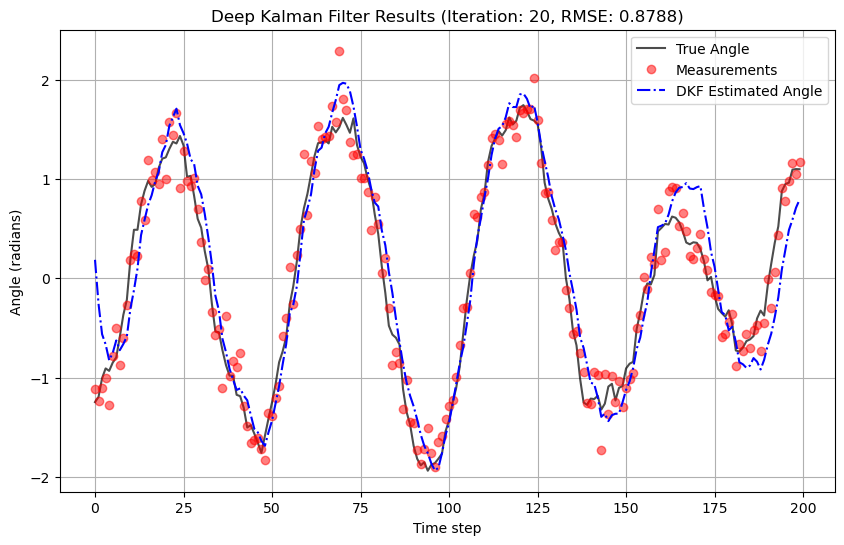

Training iteration 21...
Iteration 21, DKF RMSE: 1.1576, Avg Loss: 0.0184
Training iteration 22...
Iteration 22, DKF RMSE: 0.8740, Avg Loss: 0.0168
Training iteration 23...
Iteration 23, DKF RMSE: 0.6550, Avg Loss: 0.0166
Training iteration 24...
Iteration 24, DKF RMSE: 0.8094, Avg Loss: 0.0187
Training iteration 25...
Iteration 25, DKF RMSE: 0.8173, Avg Loss: 0.0196
Training iteration 26...
Iteration 26, DKF RMSE: 1.0270, Avg Loss: 0.0182
Training iteration 27...
Iteration 27, DKF RMSE: 0.8653, Avg Loss: 0.0182
Training iteration 28...
Iteration 28, DKF RMSE: 0.8049, Avg Loss: 0.0169
Training iteration 29...
Iteration 29, DKF RMSE: 0.7929, Avg Loss: 0.0177
Training iteration 30...
Iteration 30, DKF RMSE: 0.7750, Avg Loss: 0.0166


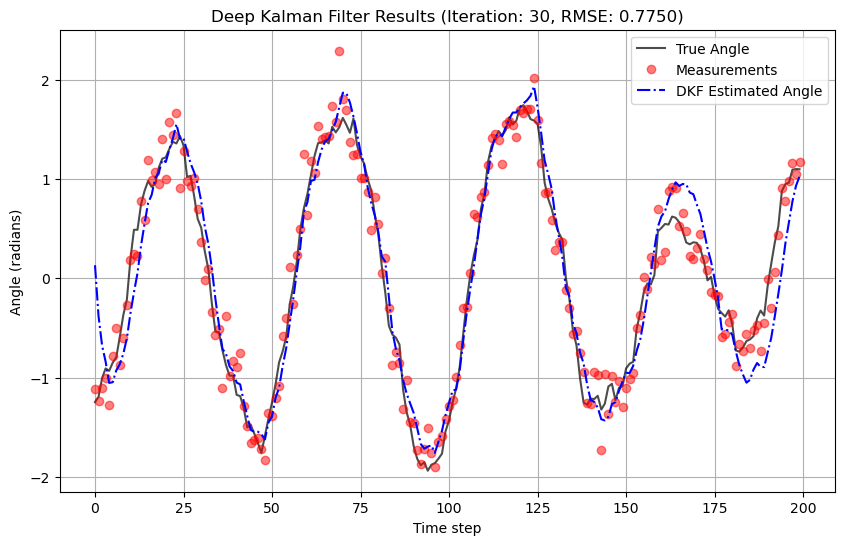

Training completed! Best DKF RMSE: 0.5798
Total iterations: 30


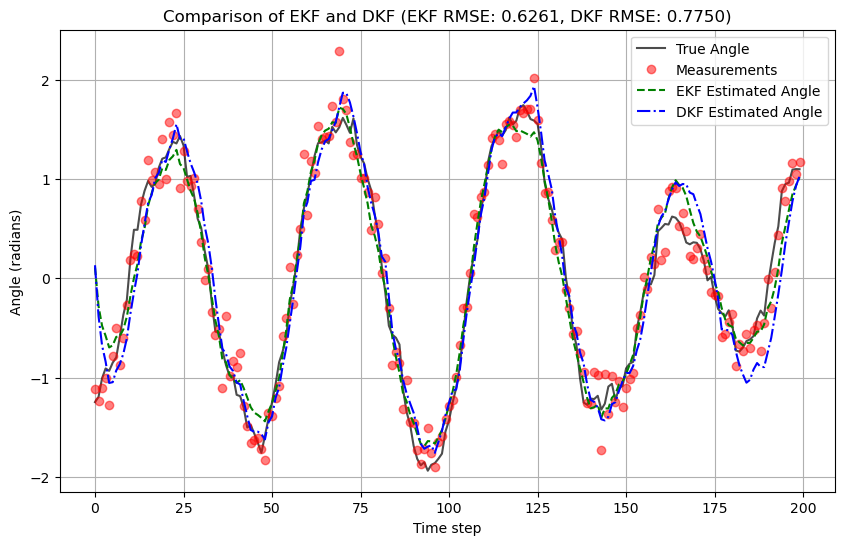

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Pendulum parameters
L = 1.0  # Length of the pendulum
g = 9.81 # Gravitational acceleration
b = 0.5 # Dampening coefficient
dt = 0.05 # Global time step

# Define the measurement matrix H
H = np.array([[1, 0]])  # Identity matrix for direct state measurement (angle

# Process and measurement noises
Q = np.diag([0.01, 0.03])  # Process noise covariance
R = 0.2    # Measurement noise covariance

# Define the non-linear state transition function
def f(state, dt):
    theta, omega = state
    new_theta = theta + omega * dt
    new_omega = omega - (g / L) * np.sin(theta) * dt - b * omega * dt
    return np.array([new_theta, new_omega])

def generate_data(num_steps):
    true_states = []
    measurements = []
    
    # Initial state [theta, omega]
    state = np.array([5.0, 1.0])  # Start at 5 degrees with initial velocity of 1
    
    for _ in range(num_steps):
        # Update state
        state = f(state, dt)
        
        # Add process noise
        state += np.random.multivariate_normal([0, 0], Q)
        state[0] = (state[0] + np.pi) % (2 * np.pi) - np.pi # Angle wrapping to avoid infinite energy explosion
        
        # Store true state
        true_states.append(state.copy())
        
        # Generate noisy measurement
        measurement = H @ state + np.random.normal(0, R)
        measurements.append(measurement)
    
    return np.array(true_states), np.array(measurements)

# Define neural network for DKF
class DKFNet(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=2, num_lstm_layers=2, num_fc_layers=3):
        super(DKFNet, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_lstm_layers, batch_first=True)
        
        fc_layers = []
        for i in range(num_fc_layers - 1):
            fc_layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
        fc_layers.append(nn.Linear(hidden_size, output_size))
        
        self.fc_layers = nn.Sequential(*fc_layers)
        
    def forward(self, x):
        # Add sequence dimension if it's missing
        if x.dim() == 2:
            x = x.unsqueeze(1)
        
        # LSTM layer
        x, _ = self.lstm(x)
        
        # Take only the last output of the LSTM
        x = x[:, -1, :]
        
        # Fully connected layers
        x = self.fc_layers(x)
        
        return x

# Training function
def train_dkf_net(dkf_net, inputs, targets, optimizer, epochs, batch_size=64):
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.MSELoss()
    dkf_net.train()
    
    total_loss = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_inputs, batch_targets in dataloader:
            optimizer.zero_grad()
            outputs = dkf_net(batch_inputs)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        total_loss += epoch_loss / len(dataloader)
    
    return total_loss / epochs  # average loss

# Implement DKF prediction
def dkf_predict(state, dkf_net):
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    with torch.no_grad():
        predicted_transition = dkf_net(state_tensor)
    
    predicted_transition = predicted_transition.squeeze().numpy()
    
    predicted_state = state + predicted_transition
    
    return predicted_state

# Implement EKF predict step
def ekf_predict(state, P, Q):
    predicted_state = f(state, dt)  # Using the non-linear transition function
    F = np.array([[1, dt], [-(g / L) * np.cos(state[0]) * dt, 1 - b * dt]])  # Jacobian of f
    P = F @ P @ F.T + Q
    return predicted_state, P

# Implement KF update step
def kf_update(state, P, measurement, R):
    y = measurement - H @ state
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    state = state + K @ y
    P = P - K @ H @ P
    return state, P

# Evaluation function
def evaluate_model(true_states, estimated_states):
    mse = np.mean((true_states - estimated_states)**2)
    rmse = np.sqrt(mse)
    return rmse

# Run DKF
def run_dkf(dkf_net, measurements):
    estimated_states = []
    state = np.array([np.pi/4, 0.0]) # Initial guess
    P = np.eye(2) * 0.1 # Initial guess

    for measurement in measurements:
        # Prediction
        state = dkf_predict(state, dkf_net)
        P = P + Q
        
        # Update
        state, P = kf_update(state, P, measurement, R)
        
        estimated_states.append(state)

    return np.array(estimated_states)

# Run KF
def run_kf(measurements):
    estimated_states = []
    state = np.array([np.pi/4, 0.0]) # Initial guess
    P = np.eye(2) * 0.1 # Initial guess

    for measurement in measurements:
        # Prediction
        state, P = ekf_predict(state, P, Q)
        
        # Update
        state, P = kf_update(state, P, measurement, R)
        
        estimated_states.append(state)

    return np.array(estimated_states)

# Plot simulation of process
def plot_simulation(true_states, measurements):
    plt.figure(figsize=(10, 6))
    plt.plot(true_states[:, 0], label='True Angle')
    plt.plot(measurements[:, 0], 'o', label='Measured Angle', alpha=0.5)
    plt.legend()
    plt.grid(True)
    plt.title("Simulation of pendulum process and measurements")
    plt.xlabel("Time step")
    plt.ylabel("Angle (radians)")
    plt.show()

# Plot results of DKF and KF
def plot_results(true_states, measurements, dkf_states, kf_states, epoch):
    plt.figure(figsize=(10, 6))
    plt.plot(true_states[:, 0], label='True Angle', alpha=0.7)
    plt.plot(measurements[:, 0], 'o', label='Measurements', alpha=0.5)
    plt.plot(dkf_states[:, 0], label='DKF Estimated Angle')
    plt.plot(kf_states[:, 0], label='KF Estimated Angle')
    plt.legend()
    plt.grid(True)
    dkf_rmse = np.sqrt(np.mean((true_states[:, 0] - dkf_states[:, 0])**2))
    kf_rmse = np.sqrt(np.mean((true_states[:, 0] - kf_states[:, 0])**2))
    plt.title(f"Kalman Filter Results (Epoch: {epoch}, DKF RMSE: {dkf_rmse:.4f}, KF RMSE: {kf_rmse:.4f})")
    plt.xlabel("Time step")
    plt.ylabel("Angle (radians)")
    plt.show()

# RMSE function
def calculate_rmse(true_states, estimated_states):
    return np.sqrt(np.mean((true_states - estimated_states)**2))


# Plot simulation of process
def plot_simulation(true_states, measurements):
    plt.figure(figsize=(10, 6))
    plt.plot(true_states[:, 0], '-', color='black', label='True Angle', alpha=0.7)
    plt.plot(measurements[:, 0], 'o', color='red', label='Measured Angle', alpha=0.5)
    plt.legend()
    plt.grid(True)
    plt.title("Simulation of pendulum process and measurements")
    plt.xlabel("Time step")
    plt.ylabel("Angle (radians)")
    plt.show()

# Plot results of EKF
def plot_ekf_results(true_states, measurements, ekf_states, rmse):
    plt.figure(figsize=(10, 6))
    plt.plot(true_states[:, 0], '-', color='black', label='True Angle', alpha=0.7)
    plt.plot(measurements[:, 0], 'o', color='red', label='Measurements', alpha=0.5)
    plt.plot(ekf_states[:, 0], '--', color='green', label='EKF Estimated Angle')
    plt.legend()
    plt.grid(True)
    plt.title(f"Extended Kalman Filter Results (RMSE: {rmse:.4f})")
    plt.xlabel("Time step")
    plt.ylabel("Angle (radians)")
    plt.show()

# Plot results of DKF
def plot_dkf_results(true_states, measurements, dkf_states, iteration, rmse):
    plt.figure(figsize=(10, 6))
    plt.plot(true_states[:, 0], '-', color='black', label='True Angle', alpha=0.7)
    plt.plot(measurements[:, 0], 'o', color='red', label='Measurements', alpha=0.5)
    plt.plot(dkf_states[:, 0], '-.', color='blue', label='DKF Estimated Angle')
    plt.legend()
    plt.grid(True)
    plt.title(f"Deep Kalman Filter Results (Iteration: {iteration}, RMSE: {rmse:.4f})")
    plt.xlabel("Time step")
    plt.ylabel("Angle (radians)")
    plt.show()

# Plot comparison of EKF and DKF
def plot_comparison(true_states, measurements, ekf_states, dkf_states, ekf_rmse, dkf_rmse):
    plt.figure(figsize=(10, 6))
    plt.plot(true_states[:, 0], '-', color='black', label='True Angle', alpha=0.7)
    plt.plot(measurements[:, 0], 'o', color='red', label='Measurements', alpha=0.5)
    plt.plot(ekf_states[:, 0], '--', color='green', label='EKF Estimated Angle')
    plt.plot(dkf_states[:, 0], '-.', color='blue', label='DKF Estimated Angle')
    plt.legend()
    plt.grid(True)
    plt.title(f"Comparison of EKF and DKF (EKF RMSE: {ekf_rmse:.4f}, DKF RMSE: {dkf_rmse:.4f})")
    plt.xlabel("Time step")
    plt.ylabel("Angle (radians)")
    plt.show()


# Main execution
if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Generate data
    true_states, measurements = generate_data(200)

    # Plot the simulation and measurements
    plot_simulation(true_states, measurements)

    # Run and evaluate EKF
    ekf_states = run_kf(measurements)  # Note: This is actually running EKF
    ekf_rmse = calculate_rmse(true_states, ekf_states)
    print(f"EKF RMSE: {ekf_rmse:.4f}")

    # Plot EKF results
    plot_ekf_results(true_states, measurements, ekf_states, ekf_rmse)

    # Prepare training data for DKF
    inputs = true_states[:-1]  # All states except the last one
    targets = true_states[1:] - true_states[:-1]  # Differences between consecutive states
    
    # Convert to numpy arrays (if they aren't already)
    inputs = np.array(inputs)
    targets = np.array(targets)
    
    # Create PyTorch tensors and move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
    targets_tensor = torch.tensor(targets, dtype=torch.float32).to(device)
    
    # Initialize model, optimizer, and scheduler
    dkf_net = DKFNet(input_size=2, output_size=2).to(device)
    optimizer = optim.Adam(dkf_net.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.9)
    
    # Training loop with RMSE threshold based on EKF performance
    epochs_per_iteration = 100
    rmse_lower_bound = max(0, ekf_rmse - 0.05)  # Ensure non-negative
    rmse_upper_bound = ekf_rmse + 0.05
    iteration = 0
    best_rmse = float('inf')
    max_iterations = 30
    patience = 50
    no_improve_count = 0
    dkf_rmse = float('inf')  # Initialize dkf_rmse

    
    
    while iteration < max_iterations:
        iteration += 1
        print(f"Training iteration {iteration}...")
        avg_loss = train_dkf_net(dkf_net, inputs_tensor, targets_tensor, optimizer, epochs=epochs_per_iteration)
        
        scheduler.step(avg_loss)
        
        # Evaluate every iteration
        dkf_states = run_dkf(dkf_net, measurements)
        dkf_rmse = calculate_rmse(true_states, dkf_states)
        print(f"Iteration {iteration}, DKF RMSE: {dkf_rmse:.4f}, Avg Loss: {avg_loss:.4f}")
        
        if dkf_rmse < best_rmse:
            best_rmse = dkf_rmse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if iteration % 10 == 0 or iteration == 1:  # Plot every 20 iterations
            plot_dkf_results(true_states, measurements, dkf_states, iteration, dkf_rmse)
        
        if no_improve_count >= patience:
            print("Early stopping triggered.")
            break
    
    print(f"Training completed! Best DKF RMSE: {best_rmse:.4f}")
    print(f"Total iterations: {iteration}")

    # Final comparison
    dkf_rmse = calculate_rmse(true_states, dkf_states)
    
    plot_comparison(true_states, measurements, ekf_states, dkf_states, ekf_rmse, dkf_rmse)
